In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import load_img
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_matrix, plot_stat_map
from gcn_package.features.graph_construction import make_group_graph
from gcn_package.data.time_windows_dataset import TimeWindowsDataset
from gcn_package.models.gcn import HaoGCN

# some parameters here
dimension = 64
window_length = 10
random_seed = 0
batch_size = 32
epochs = 30

dic_labels = {'adult': 0, 'child': 1}


data_path = Path.cwd().parents[0] / "data"  # run from repo root
participants = pd.read_csv(data_path / "raw" / "participants.tsv", index_col=0, header=0, sep='\t')

In [2]:
# get subject id and label
labels = participants['Child_Adult']

# select balanced child and adult
participants = participants[89: ]
labels = participants['Child_Adult']

In [3]:
# get atlas label
atlas_map = data_path / "raw" / "segmented_difumo_atlases" / \
    "tpl-MNI152NLin2009cAsym" / f"tpl-MNI152NLin2009cAsym_res-02_atlas-DiFuMo_desc-{dimension}dimensionsSegmented_probseg.nii.gz"
atlas_label = data_path / "raw" / "segmented_difumo_atlases" / \
    "tpl-MNI152NLin2009cAsym" / f"tpl-MNI152NLin2009cAsym_res-02_atlas-DiFuMo_desc-{dimension}dimensionsSegmented_probseg.tsv"

atlas_map = load_img(str(atlas_map))
atlas_label = pd.read_csv(atlas_label, sep='\t')
atlas_label = [f"{row['Region']}_{row['Difumo_names']}" for _, row in atlas_label.iterrows()]

In [4]:
# make a group graph
connectomes = []
for subject in labels.index:
    path = data_path / "processed" / "dataset-ds000228_timeseries" / subject / \
        f"{subject}_task-pixar_atlas-DiFuMo{dimension}dimensionsSegmented_desc-deconfounds_connectome.tsv"
    conn = pd.read_csv(path, index_col=0, header=0, sep='\t').values
    connectomes.append(conn.astype(np.float32))
average_connectome = np.mean(connectomes, axis=0)
np.fill_diagonal(average_connectome, 0)

graph = make_group_graph(connectomes, k=8)

In [5]:
# split the data by time window size and save to file
label_df = pd.DataFrame(columns=['label', 'filename'])
split_twindow_dir = data_path / "processed" / 'split_timewindow'
split_twindow_dir.mkdir(parents=True, exist_ok=True)

for subject in labels.index:
    label = labels[subject]
    ts_path = data_path / "processed" / "dataset-ds000228_timeseries" / subject / \
        f"{subject}_task-pixar_atlas-DiFuMo{dimension}dimensionsSegmented_desc-deconfounds_timeseries.tsv"
    ts_data = pd.read_csv(ts_path, index_col=False, header=0, sep='\t').values.astype(np.float32)
    ts_duration = ts_data.shape[0]
    ts_filename = f"{subject}_{label}_seg"
    valid_label = dic_labels[label]

    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))

    ts_data = ts_data[:(ts_duration - rem), :]

    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = split_twindow_dir / '{}_{:04d}.npy'.format(ts_filename, j)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)

        curr_label = {'label': valid_label, 'filename': ts_output_file_name.name}
        label_df = pd.concat((label_df, pd.DataFrame([curr_label])))

label_df.to_csv(split_twindow_dir / 'labels.csv', index=False)

In [6]:
# create dataset
train_dataset = TimeWindowsDataset(
    data_dir=split_twindow_dir,
    partition="train",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True)

valid_dataset = TimeWindowsDataset(
    data_dir=split_twindow_dir,
    partition="valid",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True)

test_dataset = TimeWindowsDataset(
    data_dir=split_twindow_dir,
    partition="test",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 739*(torch.Size([114, 10]), ())
valid dataset: 211*(torch.Size([114, 10]), ())
test dataset: 106*(torch.Size([114, 10]), ())


In [7]:
import torch
from torch.utils.data import DataLoader


torch.manual_seed(random_seed)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# parameterise YuGCN properly
gcn = HaoGCN(graph.edge_index,
            graph.edge_attr,
            batch_size=batch_size,
            n_roi=conn.shape[0],
            n_timepoints=window_length,
            n_classes=2)
gcn

HaoGCN(
  (conv1): ChebConv(10, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 32, K=2, normalization=sym)
  (conv4): ChebConv(32, 32, K=2, normalization=sym)
  (conv5): ChebConv(32, 32, K=2, normalization=sym)
  (conv6): ChebConv(32, 32, K=2, normalization=sym)
  (fc1): Linear(in_features=3648, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    training_loss, training_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.float()
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * dataloader.batch_size
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        training_loss += loss
        training_correct += correct

        correct /= X.shape[0]
        # cutting the log size
        if (batch % 10 == 0) or (current == size):
            print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")
    # training performance summary
    training_loss /= size
    training_correct /= size
    return training_loss, training_correct


def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

Epoch 1/30
-------------------------------
#    0;	train_loss: 0.733;	train_accuracy: 40.6%		[    0/  739]
#   10;	train_loss: 0.708;	train_accuracy: 59.4%		[  320/  739]
#   20;	train_loss: 0.750;	train_accuracy: 43.8%		[  640/  739]
Training metrics:
	 avg_loss: 0.024108;	 avg_accuracy: 49.9%
Valid metrics:
	 avg_loss: 0.026290;	 avg_accuracy: 49.3%
Epoch 2/30
-------------------------------
#    0;	train_loss: 0.759;	train_accuracy: 53.1%		[    0/  739]
#   10;	train_loss: 0.702;	train_accuracy: 53.1%		[  320/  739]
#   20;	train_loss: 0.663;	train_accuracy: 59.4%		[  640/  739]
Training metrics:
	 avg_loss: 0.023752;	 avg_accuracy: 53.5%
Valid metrics:
	 avg_loss: 0.026163;	 avg_accuracy: 48.8%
Epoch 3/30
-------------------------------
#    0;	train_loss: 0.701;	train_accuracy: 53.1%		[    0/  739]
#   10;	train_loss: 0.732;	train_accuracy: 50.0%		[  320/  739]
#   20;	train_loss: 0.733;	train_accuracy: 46.9%		[  640/  739]
Training metrics:
	 avg_loss: 0.023336;	 avg_accuracy: 51

#   10;	train_loss: 0.466;	train_accuracy: 84.4%		[  320/  739]
#   20;	train_loss: 0.507;	train_accuracy: 71.9%		[  640/  739]
Training metrics:
	 avg_loss: 0.016875;	 avg_accuracy: 76.7%
Valid metrics:
	 avg_loss: 0.025062;	 avg_accuracy: 54.0%
Epoch 25/30
-------------------------------
#    0;	train_loss: 0.505;	train_accuracy: 81.2%		[    0/  739]
#   10;	train_loss: 0.563;	train_accuracy: 75.0%		[  320/  739]
#   20;	train_loss: 0.406;	train_accuracy: 84.4%		[  640/  739]
Training metrics:
	 avg_loss: 0.015335;	 avg_accuracy: 78.6%
Valid metrics:
	 avg_loss: 0.023890;	 avg_accuracy: 55.9%
Epoch 26/30
-------------------------------
#    0;	train_loss: 0.408;	train_accuracy: 90.6%		[    0/  739]
#   10;	train_loss: 0.396;	train_accuracy: 84.4%		[  320/  739]
#   20;	train_loss: 0.438;	train_accuracy: 84.4%		[  640/  739]
Training metrics:
	 avg_loss: 0.015708;	 avg_accuracy: 80.2%
Valid metrics:
	 avg_loss: 0.025358;	 avg_accuracy: 59.2%
Epoch 27/30
-------------------------------

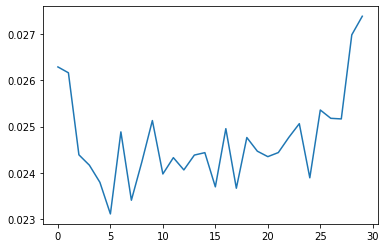

In [10]:
# training
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

training = {"loss": [], "correct": []}
validation = {"loss": [], "correct": []}
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loss, train_correct = train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Training metrics:\n\t avg_loss: {train_loss:>8f};\t avg_accuracy: {(100*train_correct):>0.1f}%")
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

    validation["loss"].append(loss)
    validation["correct"].append(correct)

plt.plot(validation["loss"])
plt.show()

In [11]:
# results
loss, correct = valid_test_loop(test_generator, gcn, loss_fn)
print(f"Test metrics:\n\t avg_loss: {loss:>f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.031373;	 avg_accuracy: 54.7%


In [12]:
# switch the model to evaluation mode
gcn.eval()

# use a hook to remove negative gradient
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)


for module in gcn.modules():
    if isinstance(module, torch.nn.ReLU):
        print(gcn.named_modules())
        module.register_backward_hook(relu_hook_function)

predictied: adult;	real: adult;	probability: 0.08357924968004227
predictied: child;	real: child;	probability: 0.12299740314483643
predictied: adult;	real: child;	probability: 0.03450653329491615
predictied: child;	real: child;	probability: 0.0966406837105751
predictied: child;	real: adult;	probability: 0.02871711179614067
predictied: child;	real: adult;	probability: 0.042752623558044434
predictied: child;	real: child;	probability: 0.022175118327140808
predictied: child;	real: child;	probability: 0.07696419209241867
predictied: child;	real: child;	probability: 0.0598209947347641
predictied: adult;	real: adult;	probability: 0.045361921191215515
predictied: child;	real: adult;	probability: 0.02658187784254551
predictied: adult;	real: child;	probability: 0.02415124513208866
predictied: child;	real: child;	probability: 0.024493291974067688
predictied: adult;	real: adult;	probability: 0.032456088811159134
predictied: adult;	real: child;	probability: 0.08517049252986908
predictied: adult;	rea

/home/haoting/.virtualenvs/gcn_developmental/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


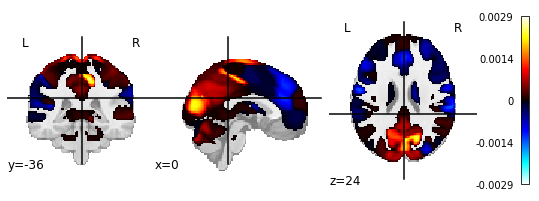

In [13]:
# forward/inference
test_features, test_label = next(iter(test_generator))
test_features.requires_grad = True
out = gcn(test_features)
probabilities = torch.nn.functional.softmax(out, dim=0)
top_prob, top_catid = torch.topk(probabilities, 1)
for i in range(top_prob.size(0)):
    print("predictied: {};\treal: {};\tprobability: {}".format(
        list(dic_labels)[top_catid[i]],
        list(dic_labels)[test_label[i]],
        top_prob[i].item()))
# backprop
out[0, top_catid].mean().backward()
grads = test_features.grad

# visualise average of all batches and time windows
np_gradient = grads.detach().numpy()
avg_grad = np_gradient.mean(axis=0).mean(axis=1)
avg_grad = (avg_grad - np.mean(avg_grad)) / np.std(avg_grad)
masker = NiftiMapsMasker(atlas_map).fit()
saliency_map = masker.inverse_transform(avg_grad)
plot_stat_map(saliency_map)
plt.show()